# Brain Tumor Segmentation with YOLO 11 and SAM2

In [1]:
!pip install ultralytics
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python-headless
!pip install matplotlib


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-appuvv3t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-appuvv3t
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/braintumorsegmentation/Training/pituitary/Tr-pi_0789.jpg
/kaggl

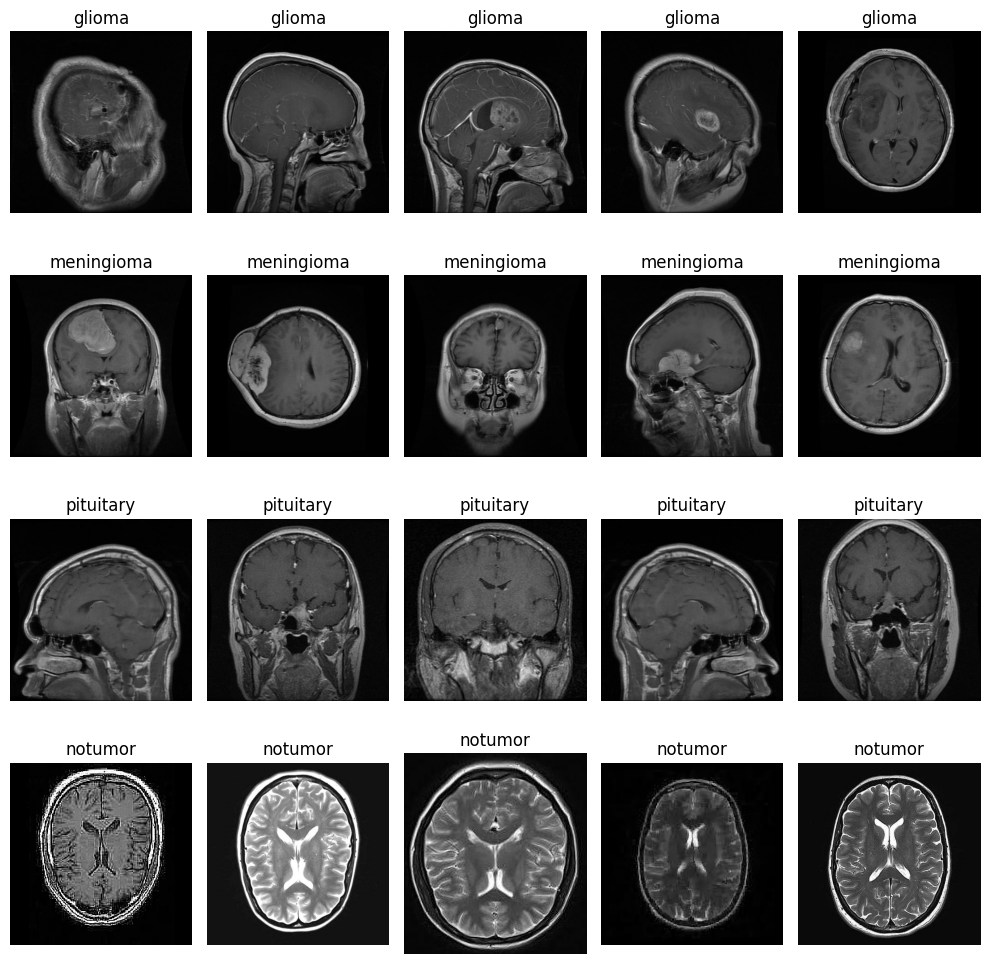

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

base_path = "/kaggle/input/braintumorsegmentation/Training"
categories = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Show sample images
fig, axes = plt.subplots(len(categories), 5, figsize=(10, 10))
for i, category in enumerate(categories):
    folder = os.path.join(base_path, category)
    images = os.listdir(folder)[:5]  # first 5 images
    for j in range(5):
        image_path = os.path.join(folder, images[j])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{category}")
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()


In [4]:
!pip install ultralytics


In [5]:
import os
import shutil
from pathlib import Path

# Dataset path (where your images are)
base_path = "/kaggle/input/braintumorsegmentation/Training"

# Classes in the dataset
categories = ['glioma', 'meningioma', 'pituitary', 'notumor']


In [6]:
# Create YOLOv8-compatible folder structure
Path("yolo/images/train").mkdir(parents=True, exist_ok=True)
Path("yolo/labels/train").mkdir(parents=True, exist_ok=True)


In [7]:
# Loop through each category, copy images, and create dummy labels
for class_id, category in enumerate(categories):
    class_folder = os.path.join(base_path, category)
    for image_name in os.listdir(class_folder):
        src_image_path = os.path.join(class_folder, image_name)
        
        # Rename image with class prefix to avoid duplicates
        new_image_name = f"{category}_{image_name}"
        dst_image_path = os.path.join("yolo/images/train", new_image_name)
        shutil.copy(src_image_path, dst_image_path)

        # Create a dummy label file (bounding box = full image)
        label_name = new_image_name.replace(".jpg", ".txt")
        label_path = os.path.join("yolo/labels/train", label_name)
        with open(label_path, "w") as f:
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")  # center x/y, width, height


In [8]:
import os

# Get absolute path to 'yolo' folder
root = os.path.abspath("yolo")

with open("braintumor.yaml", "w") as f:
    f.write(f"""
path: {root}
train: images/train
val: images/train
nc: 4
names: ['glioma', 'meningioma', 'pituitary', 'notumor']
""")


In [9]:
# Check if folders and files exist
!ls yolo/images/train | head -n 5
!ls yolo/labels/train | head -n 5
!cat braintumor.yaml


glioma_Tr-gl_0010.jpg
glioma_Tr-gl_0011.jpg
glioma_Tr-gl_0012.jpg
glioma_Tr-gl_0013.jpg
glioma_Tr-gl_0014.jpg
ls: write error: Broken pipe
glioma_Tr-gl_0010.txt
glioma_Tr-gl_0011.txt
glioma_Tr-gl_0012.txt
glioma_Tr-gl_0013.txt
glioma_Tr-gl_0014.txt
ls: write error: Broken pipe

path: /kaggle/working/yolo
train: images/train
val: images/train
nc: 4
names: ['glioma', 'meningioma', 'pituitary', 'notumor']


In [10]:
import os

dataset_path = "/kaggle/working/yolo/images/train"

total_files = 0
total_size = 0
all_folders = set()

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(root, file)
            total_size += os.path.getsize(file_path)
            total_files += 1
            all_folders.add(root)

# Convert size to MB
total_size_mb = total_size / (1024 * 1024)

print(f"📁 Total Folders: {len(all_folders)}")
print(f"🖼️ Total Images: {total_files}")
print(f"💾 Total Size: {total_size_mb:.2f} MB")


📁 Total Folders: 1
🖼️ Total Images: 5712
💾 Total Size: 126.31 MB


In [11]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="braintumor.yaml",
    epochs=50,
    imgsz=224,
    batch=16,
    name="brain_tumor_v1",
    patience=10  
)


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=braintumor.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_v12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

train: Scanning /kaggle/working/yolo/labels/train.cache... 5712 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5712/5712 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 336.5±164.0 MB/s, size: 11.9 KB)


val: Scanning /kaggle/working/yolo/labels/train.cache... 5712 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5712/5712 [00:00<?, ?it/s]


Plotting labels to runs/detect/brain_tumor_v12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/brain_tumor_v12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.326G     0.5171      1.711       1.06         50        224: 100%|██████████| 357/357 [00:32<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:25<00:00,  7.15it/s]


                   all       5712       5712      0.783      0.796      0.843       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.35G     0.3314     0.9251     0.9552         48        224: 100%|██████████| 357/357 [00:31<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:24<00:00,  7.28it/s]


                   all       5712       5712       0.75      0.718      0.846       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      0.35G     0.2984     0.8113     0.9385         50        224: 100%|██████████| 357/357 [00:29<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:24<00:00,  7.16it/s]


                   all       5712       5712      0.824      0.896      0.945      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      0.35G     0.2726     0.7409     0.9312         48        224: 100%|██████████| 357/357 [00:29<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:24<00:00,  7.37it/s]


                   all       5712       5712      0.902      0.891      0.966      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.35G     0.2411     0.6899     0.9218         50        224: 100%|██████████| 357/357 [00:29<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.61it/s]

                   all       5712       5712      0.853      0.868      0.952      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.35G     0.2322     0.6386     0.9224         48        224: 100%|██████████| 357/357 [00:29<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.75it/s]

                   all       5712       5712      0.719      0.773      0.883      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      0.35G       0.21     0.5968     0.9131         46        224: 100%|██████████| 357/357 [00:29<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:22<00:00,  7.82it/s]

                   all       5712       5712      0.858      0.863      0.952      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      0.35G     0.2024     0.5687     0.9135         49        224: 100%|██████████| 357/357 [00:29<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.68it/s]

                   all       5712       5712      0.876      0.925      0.966      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      0.35G      0.195     0.5409     0.9072         55        224: 100%|██████████| 357/357 [00:29<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.74it/s]


                   all       5712       5712      0.728       0.89      0.923      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.35G      0.187      0.524     0.9078         55        224: 100%|██████████| 357/357 [00:29<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.74it/s]


                   all       5712       5712      0.595      0.868      0.839      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.35G     0.1813     0.5153      0.904         51        224: 100%|██████████| 357/357 [00:29<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.68it/s]

                   all       5712       5712      0.849      0.878      0.944      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      0.35G     0.1709     0.5054     0.9079         38        224: 100%|██████████| 357/357 [00:29<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.72it/s]


                   all       5712       5712      0.751      0.817      0.909      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      0.35G     0.1649     0.4841     0.9028         48        224: 100%|██████████| 357/357 [00:29<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:23<00:00,  7.64it/s]

                   all       5712       5712      0.858      0.845      0.936      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      0.35G     0.1659     0.4792     0.9053         47        224: 100%|██████████| 357/357 [00:29<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:22<00:00,  7.87it/s]


                   all       5712       5712      0.673      0.933       0.91      0.903
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

14 epochs completed in 0.209 hours.
Optimizer stripped from runs/detect/brain_tumor_v12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/brain_tumor_v12/weights/best.pt, 6.2MB

Validating runs/detect/brain_tumor_v12/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 179/179 [00:26<00:00,  6.74it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5712       5712      0.902      0.891      0.966      0.957
                glioma       1321       1321      0.997      0.717       0.97      0.955
            meningioma       1339       1339      0.678      0.956       0.92      0.919
             pituitary       1457       1457      0.948      0.933      0.983      0.976
               notumor       1595       1595      0.985      0.957      0.991      0.977
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/brain_tumor_v12


In [12]:

!pip install opencv-python matplotlib


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator


# Path to the testing dataset
base_path = "/kaggle/input/braintumorsegmentation/Testing"

# Subfolders
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Collect image paths
image_paths = []
for class_name in classes:
    folder_path = os.path.join(base_path, class_name)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))

print(f"Total images found: {len(image_paths)}")




Total images found: 1311


In [14]:
# Download the model checkpoint file
!wget -O sam_vit_b.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2025-05-31 14:06:03--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.128, 18.164.78.72, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   261MB/s    in 1.4s    

2025-05-31 14:06:05 (261 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



Number of masks generated: 14


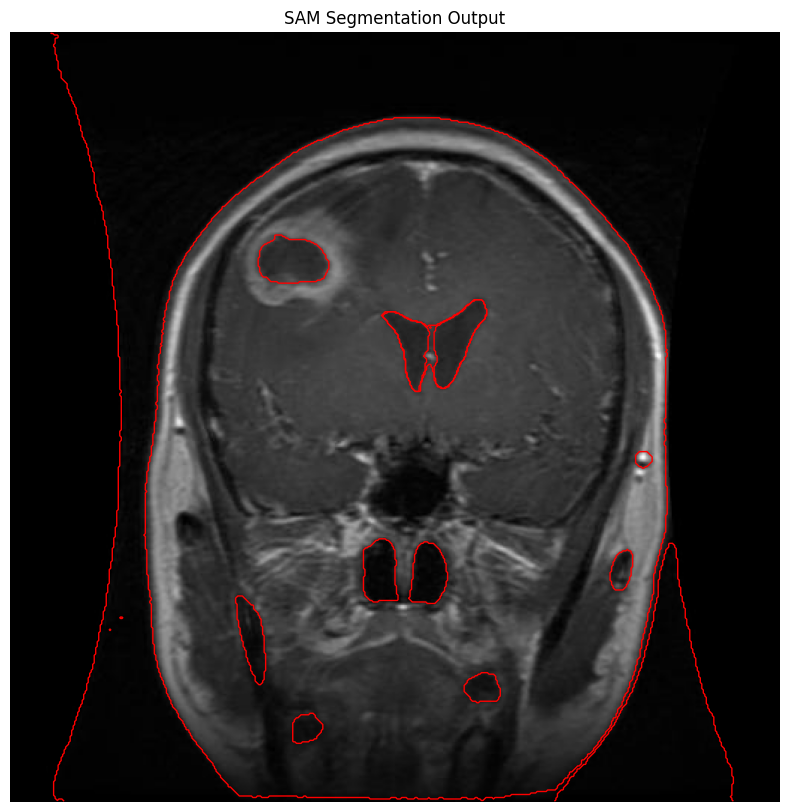

In [15]:
sam_checkpoint = "sam_vit_b.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Initialize predictor
predictor = SamPredictor(sam)


# Load one test image
test_image_path = image_paths[0]  # Change index to try other images
image = cv2.imread(test_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set image for predictor
predictor.set_image(image)


# Create automatic mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks
masks = mask_generator.generate(image)
print(f"Number of masks generated: {len(masks)}")


# Display masks overlayed on the original image
def show_masks(image, masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    for mask in masks:
        m = mask['segmentation']
        plt.contour(m, colors='red', linewidths=1)
        
    plt.axis('off')
    plt.title("SAM Segmentation Output")
    plt.show()

show_masks(image, masks)


In [ ]:
all_results = []

for img_path in image_paths:
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    predictor.set_image(image)
    masks = mask_generator.generate(image)
    
    all_results.append({
        "image_path": img_path,
        "image": image,
        "masks": masks
    })


def get_mask_path(image_path):
    # Modify according to your dataset organization
    return image_path.replace("braintumorsegmentation/Testing", "braintumorsegmentation/Testing_masks")

ground_truths = []

for img_path in image_paths:
    gt_path = get_mask_path(img_path)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is not None:
        ground_truths.append(gt_mask)
    else:
        ground_truths.append(None)  # or raise warning



def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0


ious = []

for result, gt_mask in zip(all_results, ground_truths):
    if gt_mask is None:
        continue
    
    best_iou = 0
    for m in result["masks"]:
        iou = compute_iou(m["segmentation"], gt_mask)
        best_iou = max(best_iou, iou)
    
    ious.append(best_iou)

print(f"Average IoU: {np.mean(ious):.4f}")


def get_largest_mask(masks):
    max_area = 0
    largest_mask = None
    for m in masks:
        area = m['segmentation'].sum()
        if area > max_area:
            max_area = area
            largest_mask = m['segmentation']
    return largest_mask



def visualize_prediction(image, mask, title="Filtered Mask"):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    if mask is not None:
        plt.contour(mask, colors='red', linewidths=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

for result in all_results[:5]:  # just show first 5
    mask = get_largest_mask(result["masks"])
    visualize_prediction(result["image"], mask)


